# Analyse Bike Sharing Demand

Ces données peuvent être retrouvées https://www.kaggle.com/c/bike-sharing-demand/data.


Ce projet est subdivisisé en deux parties, une première partie qui concerne un apprentissage non supervisé où nous allons laisser aux données nous livrer des informations et une seconde partie supervisée où le but sera de prédire la variable d'intérêt.

In [1]:
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans,SpectralClustering,DBSCAN





from datetime import datetime


from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import r2_score

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

In [2]:
df=pd.read_csv('train.csv',index_col='datetime',parse_dates=True)


In [3]:
df.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


## Apprentissage non supervisé

Nous avons des données de location horaires de vélos sur deux ans. L'ensemble d'entraînement sur lequel nous allons travailler comprend les 19 premiers jours de chaque mois.


Je m'intéresse uniquement à la variable **count** et sa relation avec le temps dans cette partie.
* count : le nombre total de vélos loués.



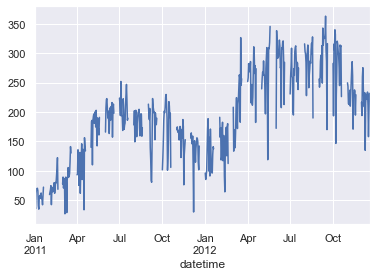

In [4]:
df.resample('D')['count'].mean().plot();

Certaines données manquent, pour chaque mois nous avons les données des 19 premiers jours. Ceci est la tendance globale du nombre de vélos loués (moyenne par jour).

On peut observer une certaine périodicité. Le nombre de vélos loués atteint un certain pic vers le mois de juillet .

Pour aller plus loin dans la compréhension du nombre de vélos loués, je trace pour chaque jour la tendance.
 
Je considére chaque jour comme une variable et chaque heure comme un individu.


In [5]:
pivot=df.pivot_table('count',index=df.index.time,columns=df.index.date)

In [6]:
pivot.head()

,2011-01-01,2011-01-02,2011-01-03,2011-01-04,2011-01-05,2011-01-06,2011-01-07,2011-01-08,2011-01-09,2011-01-10,...,2012-12-10,2012-12-11,2012-12-12,2012-12-13,2012-12-14,2012-12-15,2012-12-16,2012-12-17,2012-12-18,2012-12-19
00:00:00,16.0,17.0,5.0,5.0,6.0,11.0,17.0,25.0,25.0,5.0,...,20.0,31.0,34.0,32.0,47.0,94.0,110.0,28.0,18.0,41.0
01:00:00,40.0,17.0,2.0,2.0,6.0,4.0,7.0,16.0,12.0,1.0,...,4.0,8.0,21.0,23.0,26.0,95.0,96.0,15.0,15.0,15.0
02:00:00,32.0,9.0,NaN,1.0,2.0,2.0,1.0,16.0,11.0,3.0,...,5.0,1.0,9.0,8.0,9.0,69.0,87.0,5.0,7.0,3.0
03:00:00,13.0,6.0,NaN,NaN,NaN,NaN,NaN,7.0,4.0,1.0,...,4.0,3.0,10.0,2.0,12.0,23.0,38.0,3.0,5.0,5.0
04:00:00,1.0,3.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,3.0,...,12.0,8.0,4.0,8.0,10.0,6.0,11.0,5.0,8.0,7.0


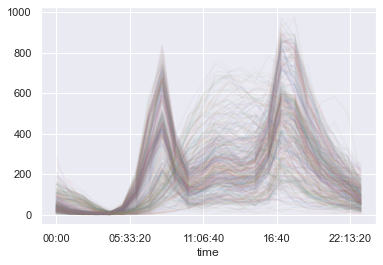

In [7]:
pivot.plot(legend=False,alpha=0.05);

Dans la figure ci-dessus est tracée toutes les courbes de tous les jours de notre base de données.

Il apparait deux tendances, une avec deux pics, et l'autre un pic.


Nous allons donc transposer, cette base de données afin d'avoir les jours comme les individus. En les projetant sur le plan de l'ACP, nous pourrons observer les différents groupes.

In [8]:
pivotT=pivot.T.fillna(0) #transpose et remplace les nan par des 0

In [9]:
# 456 lignes (le nombre de jours) et 24 colonnes( les 24 heures de la journée)
pivotT.shape 

(456, 24)

In [10]:
pca=PCA(2)  #ACP with 2 composants

X_pca=pca.fit_transform(pivotT)

In [11]:
X_pca.shape

(456, 2)

In [12]:
#Pourcentage de variance expliquée
np.cumsum(pca.explained_variance_ratio_)

array([0.59184552, 0.91922826])

Avec 2 composants principaux, nous avons plus 90% de variance expliquée.

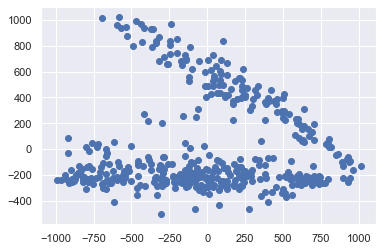

In [13]:
plt.scatter(X_pca[:,0],X_pca[:,1]);

On peut observer deux groupes dans nos données, nous allons essayer de les déterminer. Pour cela, je vais faire du clustering.

Plusieurs méthodes de clustering plus ou moins adaptées au problème existent. Pour aller loin dans les méthodes de clustering vous pouvez consulter https://scikit-learn.org/stable/modules/clustering.html.


Je vais utiliser ici le modèle GaussianMixture (un modèle génératif probabilistique qui tente de modéliser les données par un mix fini de gaussiennes). 
Pour plus de détails sur ce modèle:
* https://scikit-learn.org/stable/modules/mixture.html#gmm
* https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html



In [14]:
gmm=GaussianMixture(2,tol=1e-6,random_state=42,covariance_type='full')
label=gmm.fit(pivotT).predict(pivotT)



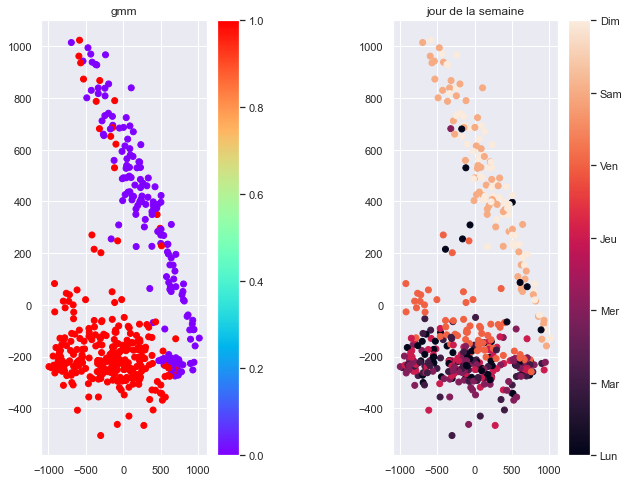

In [15]:
plt.figure(figsize=(10,8))
plt.subplots_adjust(wspace=0.7)


plt.subplot(1,2,1)
plt.scatter(X_pca[:,0],X_pca[:,1],c=label,cmap='rainbow');
plt.colorbar();
plt.title('gmm')

plt.subplot(1,2,2)
dates=pd.DatetimeIndex(pivot.columns)

plt.scatter(X_pca[:,0],X_pca[:,1],c=dates.dayofweek);
cbar=plt.colorbar(ticks=range(7));
cbar.set_ticklabels(['Lun','Mar','Mer','Jeu','Ven','Sam','Dim']);
plt.title('jour de la semaine');

Le cluster bleu correspond au weekend prédiction=0, le cluster rouge prédiction=1 correspond au jour de la semaine.
Les comportements pendant la semaine et le weekend sont différents. On peut aussi voir quelques outliers, des jours de la semaine qui ressemblent au jour du weekend.

Regardons plus en détails le comportement pendant la semaine et pendant le weekend.

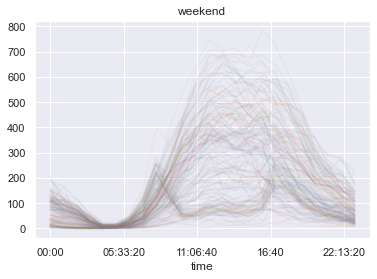

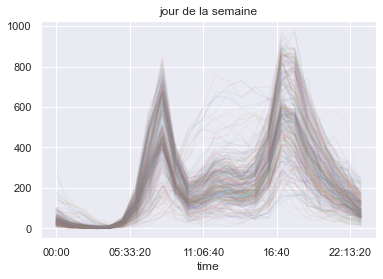

In [16]:
#Le weekend
pivotT[label==0].T.plot(legend=False,alpha=0.07)
plt.title('weekend');
#Les jours de la semaine
pivotT[label==1].T.plot(legend=False,alpha=0.07);
plt.title('jour de la semaine');

Ce poinplot donne les tendances globales journalières, cette figure vient en appui
à ce que nous avons fait.

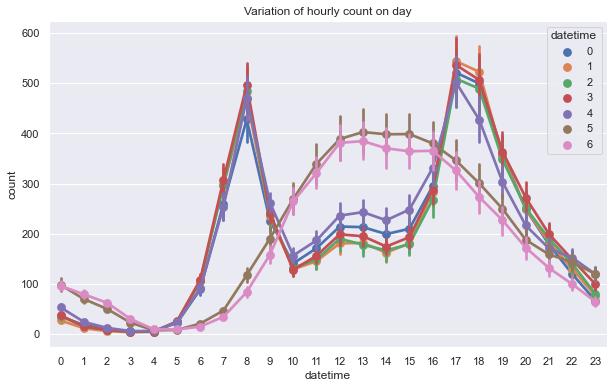

In [17]:
dayofweek=pd.Series(index=df.index,data=df.index.dayofweek)
plt.figure(figsize=(10,6))
ax = sns.pointplot(x=df.index.hour, y='count', data=df, hue=dayofweek)
ax.set_title('Variation of hourly count on day')
sns.set(style="whitegrid")

**Lundi=0 au dimanche=6**.

On voit clairement que l'utilisation du vélo pendant la semaine et pendant le weekend diffère.
Pendant la semaine, l'utilisation du vélo se fait intensément aux heures de pointe entre 5h et 10h puis entre 17h et 20h.

Pendant le weekend, c'est la pratique de loisir (en général).


Regardons quelques outliers, par exemple un jour de la semaine avec un comportement de weekend et vice versa.

In [18]:
#On crée une variable cluster 
pivotT['cluster']=label

In [19]:
#Je crée une nouvelle dataframe en groupant par date
df_by_day=df.groupby(df.index.date).mean()

df_by_day.index=pd.DatetimeIndex(df_by_day.index)

#Je joins la variable cluster dans ma nouvelle base de données
df_by_day=df_by_day.join(pivotT['cluster'],on=df_by_day.index.date)



df_by_day['Jour']=df_by_day.index.strftime('%a')

On peut regarder donc les jours de weekend qui ressemblent à un jour de la semaine.

***Jour weekend prédit dans le cluster des jours de la semaine***

In [20]:
df_by_day[(df_by_day.index.dayofweek>5) & (df_by_day.cluster==1)].shape

(6, 13)

In [21]:
df_by_day[(df_by_day.index.dayofweek>5) & (df_by_day.cluster==1)]

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,cluster,Jour
2011-04-03,2.0,0.0,0.0,1.333333,15.511667,18.938333,48.000000,12.208238,68.791667,66.583333,135.375000,1,Sun
2011-05-01,2.0,0.0,0.0,1.666667,18.518333,22.410208,76.208333,7.125729,47.416667,92.208333,139.625000,1,Sun
2012-02-05,1.0,0.0,0.0,1.708333,10.899167,13.226042,68.791667,11.791721,13.250000,109.541667,122.791667,1,Sun
2012-04-01,2.0,0.0,0.0,1.875000,17.459167,20.864375,67.625000,11.541867,97.791667,153.916667,251.708333,1,Sun
2012-09-02,3.0,0.0,0.0,1.791667,28.563333,32.450000,81.500000,4.292746,108.875000,133.208333,242.083333,1,Sun
2012-09-09,3.0,0.0,0.0,1.041667,25.010000,28.946250,54.750000,15.041221,107.083333,235.708333,342.791667,1,Sun


6 weekends présentent cette tendance avec deux pics (un comportement similaire à celui des jours de la semaine). La première observation est qu'il y'a très peu de weekends similaire aux jours de la semaine. On peut faire l'hypothèse que "**les personnes qui utilisent le vélo pour aller au travail, ne travaillent pas les weekends**".






Ensuite, on va regarder les jours de la semaine avec une resemblance à un jour de weekend.

***Jour de la semaine prédit dans le cluster des jours du weekend***

In [22]:
df_by_day[(df_by_day.index.dayofweek<5) & (df_by_day.cluster==0)].shape

(46, 13)

46 jours (entre Lundi et Vendredi) présentent cette tendance unimodale, similaire aux jours du weekend.

In [23]:
df_by_day[(df_by_day.index.dayofweek<5) & (df_by_day.cluster==0)].query('holiday==1').shape

(8, 13)

In [24]:
df_by_day[(df_by_day.index.dayofweek<5) & (df_by_day.cluster==0)].query('holiday==1').head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,cluster,Jour
2011-01-17,1.0,1.0,0.0,2.166667,7.209167,8.838542,53.750000,12.999117,4.875000,36.791667,41.666667,0,Mon
2011-09-05,3.0,1.0,0.0,2.041667,27.606667,31.282292,79.041667,14.250621,51.500000,88.125000,139.625000,0,Mon
2011-10-10,4.0,1.0,0.0,1.291667,23.404167,27.146250,73.375000,2.834379,63.083333,150.125000,213.208333,0,Mon
2011-11-11,4.0,1.0,0.0,1.000000,13.290833,15.340833,44.625000,21.083225,18.333333,122.000000,140.333333,0,Fri
2012-01-02,1.0,1.0,0.0,1.086957,11.194783,12.615217,38.130435,22.087570,10.608696,74.217391,84.826087,0,Mon


8 des jours de la semaine avec une tendance unimodale correspondent à des jours de fêtes dans notre base de données.


On s'intéresse aux autres jours qui ne sont pas des fêtes.

In [25]:
df_by_day[(df_by_day.index.dayofweek<5) & (df_by_day.cluster==0)].query('holiday==0')\
                .groupby('Jour').count().sort_values(by='count',ascending=False)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,cluster
Jour,,,,,,,,,,,,
Wed,11,11,11,11,11,11,11,11,11,11,11,11
Fri,8,8,8,8,8,8,8,8,8,8,8,8
Tue,7,7,7,7,7,7,7,7,7,7,7,7
Mon,6,6,6,6,6,6,6,6,6,6,6,6
Thu,6,6,6,6,6,6,6,6,6,6,6,6


Il y'a plus de mercredis qui ressemblent aux weekends suivi des vendredis.

On va regarder ce qui s'est passé les mercredis.

In [26]:
df_by_day[(df_by_day.Jour=='Wed') & (df_by_day.cluster==0)].query('holiday==0')

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,cluster,Jour
2011-01-05,1.0,0.0,1.0,1.000000,9.305217,11.463478,43.695652,12.522300,3.565217,66.000000,69.565217,0,Wed
2011-01-12,1.0,0.0,1.0,1.090909,7.081818,8.023636,59.954545,20.410027,1.136364,51.681818,52.818182,0,Wed
2011-01-19,1.0,0.0,1.0,1.652174,11.979130,14.921087,74.173913,13.957265,3.391304,68.347826,71.739130,0,Wed
2011-02-02,1.0,0.0,1.0,1.916667,10.660000,12.720833,77.541667,17.708658,3.000000,60.583333,63.583333,0,Wed
2011-02-09,1.0,0.0,1.0,1.652174,5.526087,7.214130,49.478261,12.652222,2.304348,67.478261,69.782609,0,Wed
2011-02-16,1.0,0.0,1.0,1.130435,13.048696,15.810000,42.347826,16.870017,9.478261,82.478261,91.956522,0,Wed
2011-03-02,1.0,0.0,1.0,1.000000,13.735000,16.003542,44.958333,20.624833,9.625000,79.291667,88.916667,0,Wed
2011-03-16,1.0,0.0,1.0,2.043478,14.973913,18.346522,77.652174,13.608865,13.956522,81.347826,95.304348,0,Wed
2011-04-13,2.0,0.0,1.0,2.000000,16.912500,20.864167,81.916667,16.791317,8.708333,81.375000,90.083333,0,Wed
2011-10-19,4.0,0.0,1.0,2.652174,22.211304,25.692391,89.521739,16.303722,11.043478,94.347826,105.391304,0,Wed


In [27]:
df[['atemp','humidity','windspeed','weather']].describe()

,atemp,humidity,windspeed,weather
count,10886.000000,10886.000000,10886.000000,10886.000000
mean,23.655084,61.886460,12.799395,1.418427
std,8.474601,19.245033,8.164537,0.633839
min,0.760000,0.000000,0.000000,1.000000
25%,16.665000,47.000000,7.001500,1.000000
50%,24.240000,62.000000,12.998000,1.000000
75%,31.060000,77.000000,16.997900,2.000000
max,45.455000,100.000000,56.996900,4.000000


En regardant la moyenne des températures ressenties **atemp** pour ces jours ci, comparer aux moyennes globales des températures ressenties, on voit qu'elles sont en général très inférieures, donc c'était des jours particulièrement froids.

On peut pousser l'analyse de ces outliers, au lieu de regarder des moyennes, prendre chaque jour et regarder les différentes variations de ses variables.

### Apprentissage Supervisé sur les données

Les différentes variables sont les suivantes, la variable à prédire est **count**.


* datetime : hourly date + timestamp  
* season :  1 = spring, 2 = summer, 3 = fall, 4 = winter 
* holiday : whether the day is considered a holiday
* workingday - whether the day is neither a weekend nor holiday
* weather : 
        1: Clear, Few clouds, Partly cloudy, Partly cloudy
        2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
        3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
        4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
* temp : temperature in Celsius
* atemp : "feels like" temperature in Celsius
* humidity : relative humidity
* windspeed : wind speed
* casual : number of non-registered user rentals initiated
* registered : number of registered user rentals initiated
* count : number of total rentals

Le travail se déroule comme suit:
* Analyse du lien entre la variable count et les autres
* Modélisation
* Validation

In [28]:
df.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


Je n'utiliserai pas les variables casual et registered, leurs informations sont déjà dans notre variable count. 

In [29]:
print(np.corrcoef(df['temp'],df['atemp']))

[[1.         0.98494811]
 [0.98494811 1.        ]]


Je vais également enlever la variable température qui est fortement corrélée à la variable atemp. Nous gardons la température ressentie.

In [30]:

df=df.drop(['casual','registered','temp'],axis=1)
df.head()

,season,holiday,workingday,weather,atemp,humidity,windspeed,count
datetime,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,14.395,81,0.0,16
2011-01-01 01:00:00,1,0,0,1,13.635,80,0.0,40
2011-01-01 02:00:00,1,0,0,1,13.635,80,0.0,32
2011-01-01 03:00:00,1,0,0,1,14.395,75,0.0,13
2011-01-01 04:00:00,1,0,0,1,14.395,75,0.0,1


In [31]:
#Pour vérifier si nos données possédent des valeurs manquantes
df.isnull().any()

season        False
holiday       False
workingday    False
weather       False
atemp         False
humidity      False
windspeed     False
count         False
dtype: bool

Notre base de données ne contient pas de valeurs manquantes.

Text(0.5, 1.0, 'Nombre de vélos loués en fonction de la vitesse du vent')

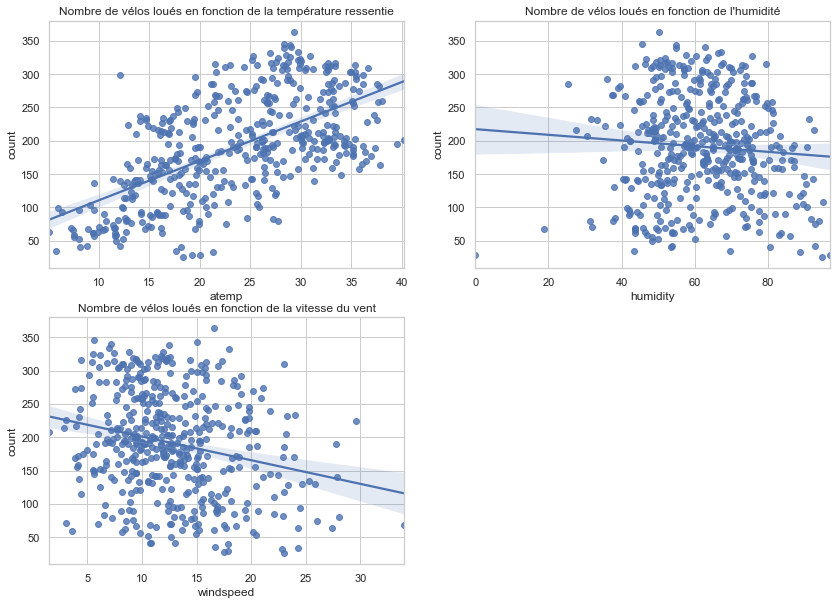

In [32]:
plt.figure(figsize=(14,10))

by_date=df.resample('D').mean()

plt.subplot(2,2,1)
sns.regplot(x="atemp", y="count",data=by_date);
plt.title('Nombre de vélos loués en fonction de la température ressentie')

plt.subplot(2,2,2)
sns.regplot(x="humidity", y="count",data=by_date);
plt.title("Nombre de vélos loués en fonction de l'humidité")

plt.subplot(2,2,3)
sns.regplot(x="windspeed", y="count",data=by_date);
plt.title('Nombre de vélos loués en fonction de la vitesse du vent')

La variable **count** est corrélée positivement à la température et négativement avec l'humidité et la vitesse du vent.

Autrement dit, si la température augmente le nombre de vélos loués peut augmenter, mais elle diminue quand l'humidité ou la vitesse du vent augmente.

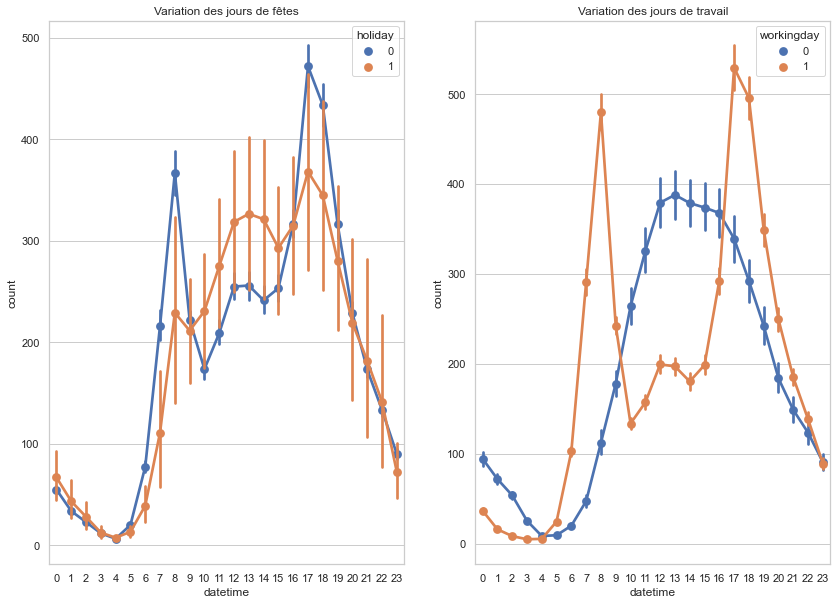

In [33]:
plt.figure(figsize=(14,10))
plt.subplot(1,2,1)
sns.pointplot(x=df.index.hour, y='count', data=df, hue='holiday')
plt.title('Variation des jours de fêtes')
sns.set(style="whitegrid")

plt.subplot(1,2,2)
sns.pointplot(x=df.index.hour, y='count', data=df, hue='workingday')
plt.title('Variation des jours de travail')
sns.set(style="whitegrid")

J'ai essayé de regardé ici comment le nombre de vélos loués varient en fonction du jour  (fête ou jour de travail).

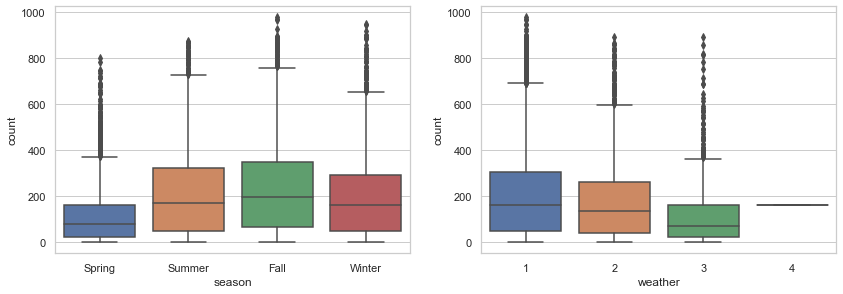

In [34]:
plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
sns.boxplot(x='season',y='count',data=df);
plt.xticks(np.arange(4),['Spring','Summer','Fall','Winter'])

plt.subplot(2,2,2)
sns.boxplot(x='weather',y='count',data=df);



Il y'a plus de vélos loués pendant l'été et l'automne, et moins pendant le printemps, on peut également voir beaucoup de valeurs extrêmes en fonction des saisons.

Plus le temps est clair (pas très nuageux), plus on a de vélos loués.

Je convertis les variables catégorielles **weather, holiday, season, workingday** en dummy variables (dummy encoding).

J'ajoute également des variables **year, month, day, hour**, nous avons vu dans la partie non supervisée leurs relations avec le nombre de vélos loués.

In [35]:
df=pd.get_dummies(df,columns=['weather','holiday','season','workingday'],drop_first=True)
df['year']=df.index.year
df['month']=df.index.month
df['day']=df.index.dayofweek
df['hour']=df.index.hour

In [36]:
df.head()

,atemp,humidity,windspeed,count,weather_2,weather_3,weather_4,holiday_1,season_2,season_3,season_4,workingday_1,year,month,day,hour
datetime,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,14.395,81,0.0,16,0,0,0,0,0,0,0,0,2011,1,5,0
2011-01-01 01:00:00,13.635,80,0.0,40,0,0,0,0,0,0,0,0,2011,1,5,1
2011-01-01 02:00:00,13.635,80,0.0,32,0,0,0,0,0,0,0,0,2011,1,5,2
2011-01-01 03:00:00,14.395,75,0.0,13,0,0,0,0,0,0,0,0,2011,1,5,3
2011-01-01 04:00:00,14.395,75,0.0,1,0,0,0,0,0,0,0,0,2011,1,5,4


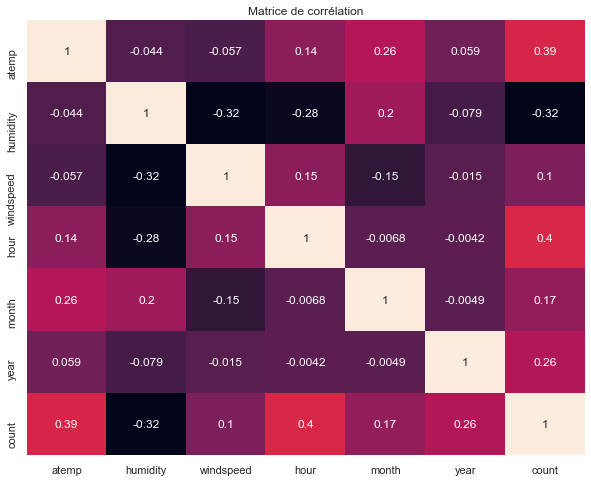

In [37]:
plt.figure(figsize=(10,8))
matC=df[['atemp','humidity','windspeed','hour','month','year','count']].corr()

sns.heatmap(matC,annot=True,cbar=False)
plt.title('Matrice de corrélation')

plt.show()

La variable qui semble la plus corrélée à **count** est **hour**, pour ces variables.

### Modélisation

In [38]:
X=df.drop('count',axis=1)
y=df['count']

Xtrain,Xtest,ytrain,ytest=train_test_split(X,y,test_size=0.1,random_state=42)

Je vous partage le lien scikit learn pour les méthodes ensemblistes https://scikit-learn.org/stable/modules/ensemble.html.

In [39]:
#Un dictionnaire de méthodes ensemblistes

regs = {
'RF': RandomForestRegressor(random_state=42),  
'BG': BaggingRegressor (random_state=42), 
'AR': AdaBoostRegressor(random_state=42)    
}

In [40]:
#La fonction run_regression permet d'avoir la performance des différents algorithmes
#Le score considéré ici est le coefficient de détermination R2
kf = KFold(n_splits=3, shuffle=True, random_state=0) 
def run_regression(regs,X,Y):
    for i in regs:
        start=datetime.now()
        reg= regs[i]
        cv_acc = cross_val_score(reg, X, Y, cv=kf)
        end=datetime.now()
        print("R2 for {0} is: {1:.3f} +/- {2:.3f}".format(i, np.mean(cv_acc), np.std(cv_acc)))
        print('time : ',end-start)
        


In [41]:
run_regression(regs,X,y)

R2 for RF is: 0.945 +/- 0.002
time :  0:00:08.724551
R2 for BG is: 0.938 +/- 0.002
time :  0:00:00.914932
R2 for AR is: 0.653 +/- 0.019
time :  0:00:01.548289


Random forest semble mieux marcher que les autres modèles. Nous allons essayer de tuner ses paramètres pour améliorer notre modèle.

In [50]:
'''
n_estmators: le nombre d'arbres dans la forêt
max_depth: La profondeur de chaque arbre 

'''


paramsRF={'n_estimators':[50,100,150,200],
       'max_depth':[4,8,13,15,20]}
grid=GridSearchCV(estimator=RandomForestRegressor(random_state=42),param_grid=paramsRF,scoring='r2').fit(Xtrain,ytrain)

In [51]:
print(grid.best_estimator_)

RandomForestRegressor(max_depth=20, n_estimators=150, random_state=42)


In [52]:
print('train score :',grid.score(Xtrain,ytrain))

print('test score: ', grid.score(Xtest,ytest))

train score : 0.9929621002606712
test score:  0.9523723282029776


Random Forest prédit à 95% le nombre de vélos loués sur de nouvelles données. Nous pouvons par exemple regarder la variable la plus importante dans la décision de random forest.

Text(0.5, 1.0, 'Importance des variables')

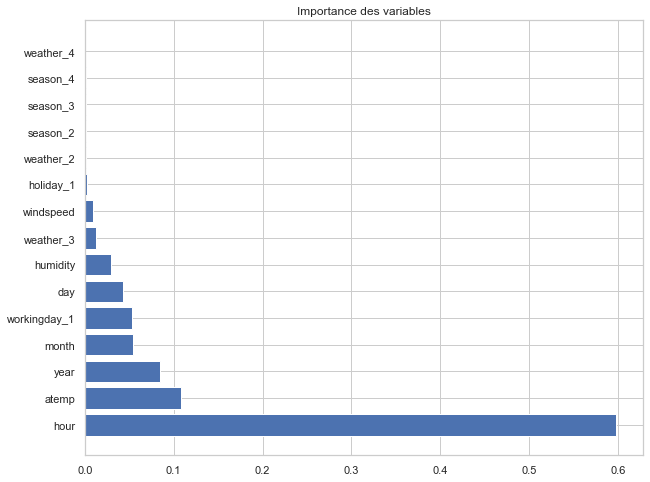

In [53]:
#Ce code permet d'afficher l'importance de chacunes des variables
plt.figure(figsize=(10,8))
importances=grid.best_estimator_.feature_importances_
sorted_idx = np.argsort(importances)[::-1]
features =df.columns.drop('count').values # On concatène ACP et les variables
plt.barh(range(len(importances)), importances[sorted_idx],align='center',tick_label=features[sorted_idx]);
plt.title('Importance des variables')


La variable la plus importante dans la décision de random forest est l'heure, suivi de la température ressentie.

### Conclusion

Je termine cette étude par là.

* On pourrait encore s'attarder sur l'analyse des outliers dans la phase non supervisée
* Analyser chaque variable individuellement dans la phase supervisée
* Se poser d'autres questions 


sources: 
 * https://jakevdp.github.io/PythonDataScienceHandbook/
 * https://www.kaggle.com/c/bike-sharing-demand/data
 * https://stackoverflow.com/